# Captioner Evaluation

In [1]:
import os
import torch
from torch import nn
import torchinfo
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2 as cv
from tqdm import tqdm
import pickle
# from pycocotools.coco import COCO

# scripts
from training import get_transform_list, get_dataset, Subset, get_distilgpt2_srn18_vae, seed_torch

os.environ["CUDA_VISIBLE_DEVICES"] = '0'


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using', device)

using cuda


In [3]:
SEED = 13
DATA_DIR = "data/mscoco"

transform_list = get_transform_list()

# get datasets
val_ds = get_dataset(transform_list, dataset_type="val2014", data_dir=DATA_DIR, seed=SEED)
seed_torch(SEED)


loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


In [4]:
print('val:\t', len(val_ds))

val:	 40504


In [5]:
random_gen = random.Random(SEED)

# Generate random indices
n_subset = 10_000
val_idxs = random_gen.sample(range(len(val_ds)), n_subset)

# sample subsets
val_subset = Subset(val_ds, val_idxs)
print('val subset:\t', len(val_subset))

val subset:	 10000


In [6]:
param_dict = {
	'captioner_weights': "logs/tests/srn18_vae_dgpt2_z3/best.pth",
	'mixed_precision': 1,
    'freeze_encoder': 0, # only affects things if ur finetuning the model
}
model = get_distilgpt2_srn18_vae(param_dict)
model.eval()
model = model.to(device)

loading captioner weights from: logs/tests/srn18_vae_dgpt2_z3/best.pth


In [7]:
val_generated_captions = model.generate_batch_captions(val_subset, max_workers=32)

started generation supervisor...


main:   0%|          | 0/10000 [00:00<?, ?it/s]

[w:   0] [i: ?] |            | , status=starting up

[w:   1] [i: ?] |            | , status=starting up

[w:   2] [i: ?] |            | , status=starting up

[w:   3] [i: ?] |            | , status=starting up

[w:   4] [i: ?] |            | , status=starting up

[w:   5] [i: ?] |            | , status=starting up

[w:   6] [i: ?] |            | , status=starting up

[w:   7] [i: ?] |            | , status=starting up

[w:   8] [i: ?] |            | , status=starting up

[w:   9] [i: ?] |            | , status=starting up

[w:  10] [i: ?] |            | , status=starting up

[w:  11] [i: ?] |            | , status=starting up

[w:  12] [i: ?] |            | , status=starting up

[w:  13] [i: ?] |            | , status=starting up

[w:  14] [i: ?] |            | , status=starting up

[w:  15] [i: ?] |            | , status=starting up

[w:  16] [i: ?] |            | , status=starting up

[w:  17] [i: ?] |            | , status=starting up

[w:  18] [i: ?] |            | , status=starting up

[w:  19] [i: ?] |            | , status=starting up

[w:  20] [i: ?] |            | , status=starting up

[w:  21] [i: ?] |            | , status=starting up

[w:  22] [i: ?] |            | , status=starting up

[w:  23] [i: ?] |            | , status=starting up

[w:  24] [i: ?] |            | , status=starting up

[w:  25] [i: ?] |            | , status=starting up

[w:  26] [i: ?] |            | , status=starting up

[w:  27] [i: ?] |            | , status=starting up

[w:  28] [i: ?] |            | , status=starting up

[w:  29] [i: ?] |            | , status=starting up

[w:  30] [i: ?] |            | , status=starting up

[w:  31] [i: ?] |            | , status=starting up

In [8]:
subset_idx_to_original_dict = {str(i):idx for i,idx in enumerate(val_subset.indices)}

In [18]:
subset_idx_to_original_dict

{'0': 16974,
 '1': 19055,
 '2': 12171,
 '3': 15109,
 '4': 9644,
 '5': 14756,
 '6': 12279,
 '7': 8533,
 '8': 4641,
 '9': 34820,
 '10': 14018,
 '11': 19310,
 '12': 1964,
 '13': 28284,
 '14': 8276,
 '15': 39872,
 '16': 945,
 '17': 18077,
 '18': 9614,
 '19': 5567,
 '20': 17199,
 '21': 29561,
 '22': 28623,
 '23': 9142,
 '24': 16823,
 '25': 23313,
 '26': 15337,
 '27': 31901,
 '28': 36025,
 '29': 36971,
 '30': 28152,
 '31': 23868,
 '32': 28168,
 '33': 20562,
 '34': 7691,
 '35': 22674,
 '36': 38972,
 '37': 17228,
 '38': 29384,
 '39': 36321,
 '40': 40054,
 '41': 8837,
 '42': 28860,
 '43': 29058,
 '44': 35125,
 '45': 11575,
 '46': 19222,
 '47': 13279,
 '48': 11757,
 '49': 34255,
 '50': 23347,
 '51': 16601,
 '52': 24321,
 '53': 30111,
 '54': 17154,
 '55': 39681,
 '56': 18359,
 '57': 25936,
 '58': 8570,
 '59': 37827,
 '60': 32168,
 '61': 36046,
 '62': 15430,
 '63': 37051,
 '64': 15445,
 '65': 12744,
 '66': 24015,
 '67': 8591,
 '68': 4802,
 '69': 28205,
 '70': 30385,
 '71': 25538,
 '72': 142,
 '73'

In [9]:
translated_captions = []
for caption_dict in val_generated_captions:
    subset_idx = caption_dict["idx"]
    original_idx = subset_idx_to_original_dict[str(subset_idx)]
    translated_captions.append({**caption_dict, "idx": original_idx})


In [10]:
pickle_file_path = "captioner_val10k.pickle"

In [11]:
with open(pickle_file_path, 'wb') as handle:
    pickle.dump(translated_captions, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
val_ds[19055]

{'image': Image([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],
 
        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],
 
        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], ),
 'caption': 'A man holding a cart seat while standing next to a little girl.'}

In [12]:
with open(pickle_file_path, 'rb') as handle:
    mia_loaded_captions = pickle.load(handle)

mia_loaded_captions

[{'idx': 16974,
  'ids': [50256,
   32,
   582,
   10311,
   1341,
   271,
   866,
   257,
   6729,
   5017,
   22638,
   13,
   50256],
  'tokens': 'A man riding skis down a snow covered slope.'},
 {'idx': 19055,
  'ids': [50256, 32, 2042, 290, 2330, 4590, 286, 257, 8801, 10580, 13, 50256],
  'tokens': 'A black and white photo of a clock tower.'},
 {'idx': 12171,
  'ids': [50256, 32, 1448, 286, 661, 5055, 1306, 284, 1123, 584, 13, 50256],
  'tokens': 'A group of people standing next to each other.'},
 {'idx': 15109,
  'ids': [50256,
   32,
   37370,
   21223,
   5055,
   1306,
   284,
   257,
   13510,
   13990,
   13,
   50256],
  'tokens': 'A giraffe standing next to a wooden fence.'},
 {'idx': 9644,
  'ids': [50256, 32, 582, 290, 257, 2415, 2712, 257, 2008, 983, 13, 50256],
  'tokens': 'A man and a woman playing a video game.'},
 {'idx': 14756,
  'ids': [50256,
   32,
   582,
   10311,
   257,
   22647,
   3526,
   510,
   262,
   1735,
   286,
   257,
   10454,
   13,
   50256],
 

In [21]:
def torch_to_plt(img, to_uint8: bool = False):
    if to_uint8:
        return cv.cvtColor(np.moveaxis((img.numpy()*255).astype(np.uint8), 0, 2), cv.COLOR_BGR2RGB)
    else:
        return cv.cvtColor(np.moveaxis(img.numpy(), 0, 2), cv.COLOR_BGR2RGB)

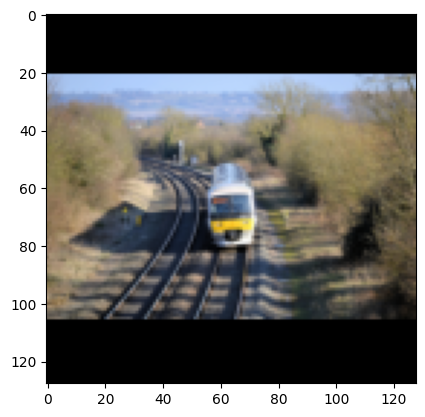


true: A yellow and white train is coming down the tracks
pred: A black and white photo of a train on the tracks.



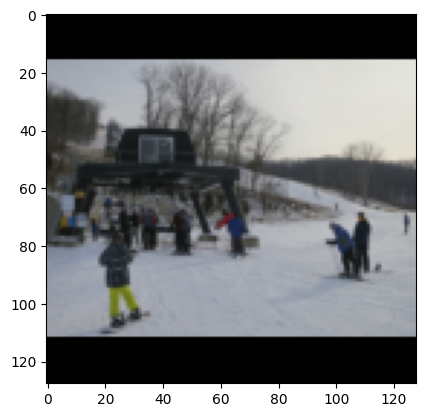


true: People lining up to catch a ride on the ski lift
pred: A man riding skis down a snow covered slope.



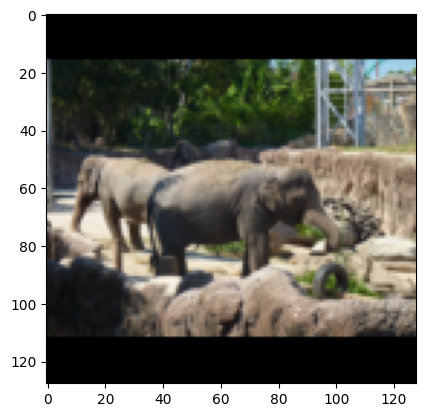


true: And elephant eating grass at the zoo with other elephants behind him.
pred: A group of elephants standing next to each other.



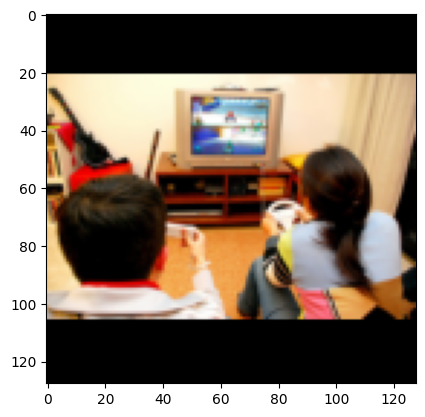


true: A guy and a girl playing a video game on the Nintendo Wii.
pred: A group of people sitting around a table eating food.



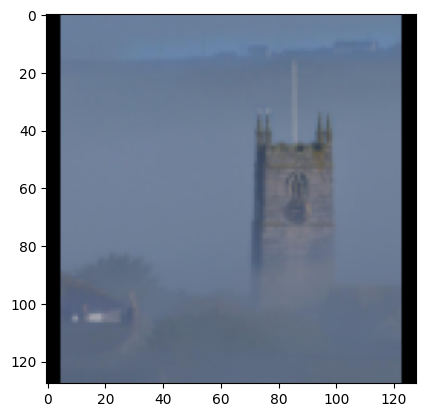


true: This is a view of a foggy day in the countryside.
pred: A large jetliner flying through a cloudy blue sky.



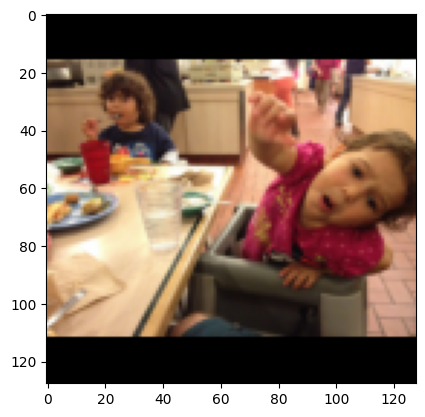


true: Two children play while eating in a restaurant.
pred: A man and a woman standing next to each other.



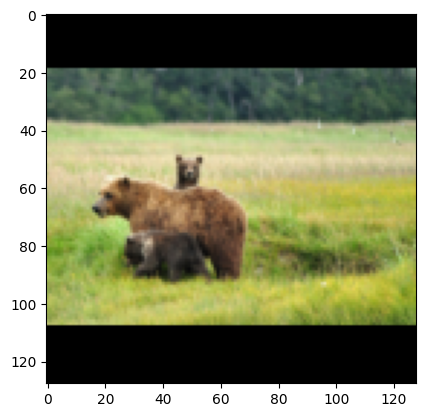


true: One bear and two cubs in the grass while birds fly behind them.
pred: A herd of cattle grazing on a lush green field.



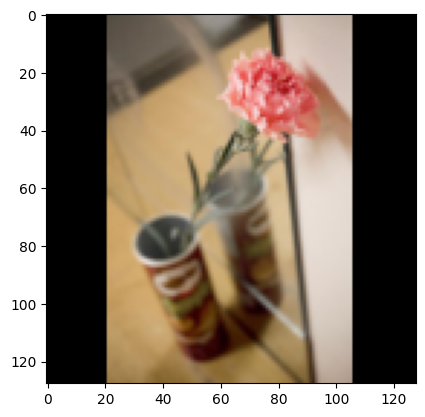

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].



true: A Pringles can as a vase with a  pink carnation.
pred: A bathroom with a toilet, sink and mirror.



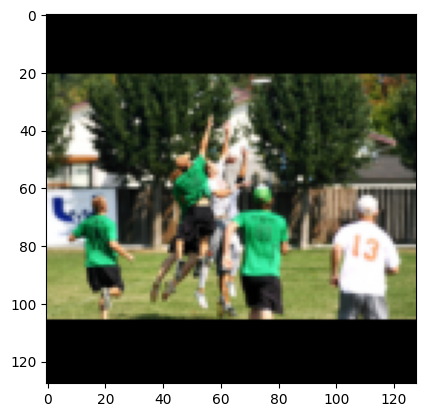


true: Several people jump to try to catch a frisbee.
pred: A group of young men playing a game of frisbee.



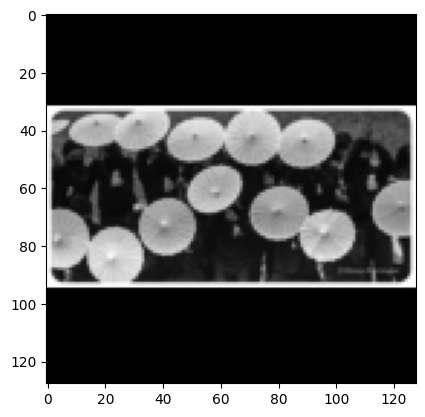


true: Several people in matching black outfits holding umbrellas.
pred: A man riding a skateboard up the side of a ramp.



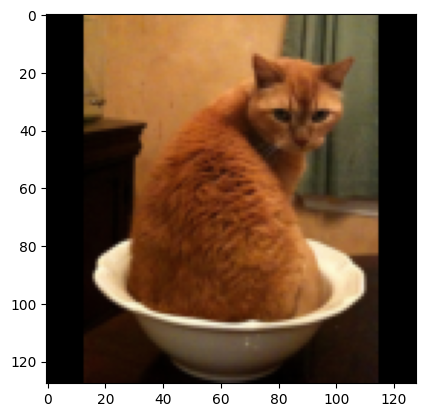


true: A cat is sitting in a white bowl.
pred: A bowl of fruit sitting on a table.



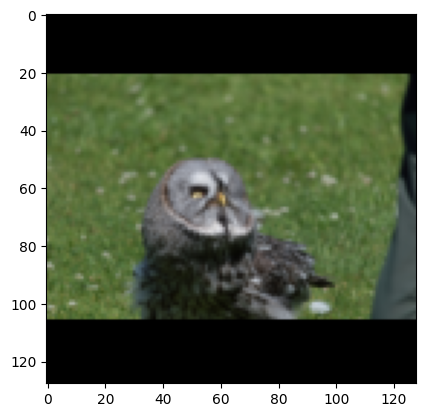


true: An owl is sitting int he grass looking up.
pred: A zebra standing on top of a grass covered field.



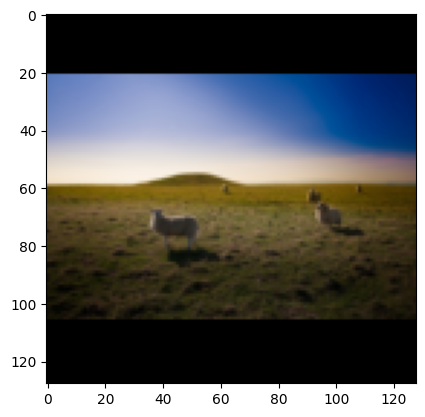


true: Sheep scattered in an open grassy field with a lone hill behind them.
pred: A herd of cattle grazing on a lush green field.



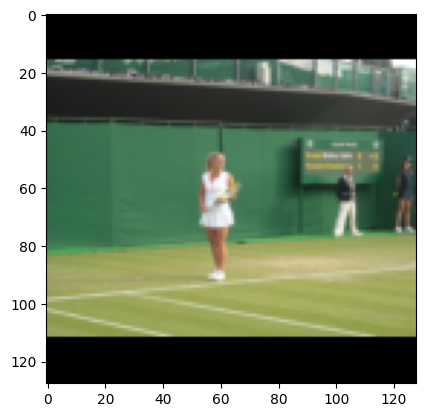


true: A female tennis player ready to serve in a match.
pred: A group of men on a field playing baseball.



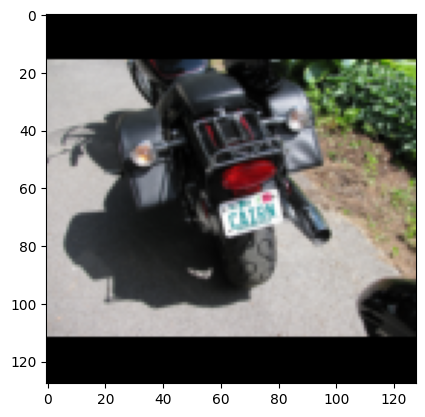


true: a close up of a motorcycle license plate
pred: A black and white photo of a man in a suit and tie.



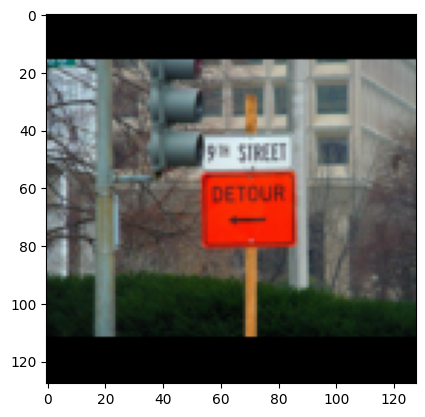


true: A street sign above an orange detour sign.
pred: A teddy bear sitting on top of a pile of books.



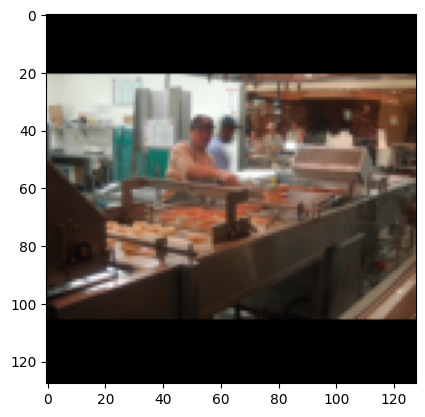


true: A cook is seen in a open kitchen making donuts
pred: A group of people standing around a kitchen preparing food.



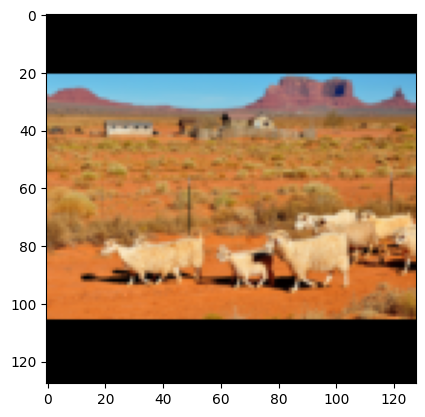


true: Some animals are walking down the road on a hot day.
pred: A group of giraffes that are standing in the dirt.



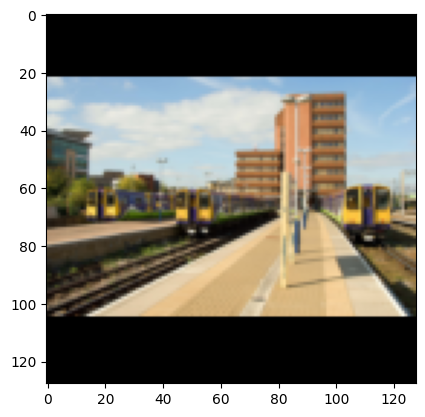


true: A train station with three trains near a building
pred: A man riding a skateboard up the side of a ramp.



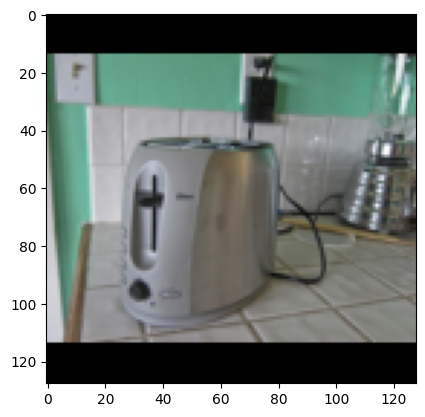


true: A toaster sits on a kitchen shelf in front of a blender.
pred: A group of elephants that are standing in the dirt.



In [22]:
for caption_dict in random.sample(mia_loaded_captions, 20):
    idx = caption_dict['idx']
    pred_caption = caption_dict['tokens']
    val_dict = val_ds[idx]
    true_caption = val_dict['caption']

    plt.imshow(torch_to_plt(val_dict['image']))
    plt.show()
    
    print(f'\ntrue: {true_caption}')
    print(f'pred: {pred_caption}\n')

In [17]:
val_subset.dataset == val_ds

True